## `DeepMTS` in nnetsauce v0.16.0 for Multivariate time series (MTS)

**Contents**

- 1 - Install
- 2 - DeepMTS

# **1 - Install**

In [35]:
!pip install git+https://github.com/Techtonique/nnetsauce.git@dev-branch

  Cloning https://github.com/Techtonique/nnetsauce.git (to revision dev-branch) to /tmp/pip-req-build-j2avpy9m
  Running command git clone --filter=blob:none --quiet https://github.com/Techtonique/nnetsauce.git /tmp/pip-req-build-j2avpy9m
  Running command git checkout -b dev-branch --track origin/dev-branch
  Switched to a new branch 'dev-branch'
  branch 'dev-branch' set up to track 'origin/dev-branch'.
  Resolved https://github.com/Techtonique/nnetsauce.git to commit 483ae50294deada95b7451030febf70c02ead704
  Preparing metadata (setup.py) ... done


In [36]:
!pip install statsmodels

In [37]:
import nnetsauce as ns
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str

# **2 - `DeepMTS`**

Macro data

In [38]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

print(mdata.head())

#mdata = mdata[['realgdp','realcons','realinv', 'realgovt',
#               'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp',
#               'pop']]

mdata = mdata[['realgovt', 'tbilrate']]

mdata.index = pd.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()

#data = mdata

display(data)

     year  quarter  realgdp  realcons  realinv  realgovt  realdpi   cpi  \
0 1959.00     1.00  2710.35   1707.40   286.90    470.05  1886.90 28.98   
1 1959.00     2.00  2778.80   1733.70   310.86    481.30  1919.70 29.15   
2 1959.00     3.00  2775.49   1751.80   289.23    491.26  1916.40 29.35   
3 1959.00     4.00  2785.20   1753.70   299.36    484.05  1931.30 29.37   
4 1960.00     1.00  2847.70   1770.50   331.72    462.20  1955.50 29.54   

      m1  tbilrate  unemp    pop  infl  realint  
0 139.70      2.82   5.80 177.15  0.00     0.00  
1 141.70      3.08   5.10 177.83  2.34     0.74  
2 140.50      3.82   5.30 178.66  2.74     1.09  
3 140.00      4.33   5.60 179.39  0.27     4.06  
4 139.60      3.50   5.20 180.01  2.31     1.19  


,realgovt,tbilrate
1959-06-30,0.02,0.09
1959-09-30,0.02,0.22
1959-12-31,-0.01,0.13
1960-03-31,-0.05,-0.21
1960-06-30,-0.00,-0.27
...,...,...
2008-09-30,0.03,-0.40
2008-12-31,0.02,-2.28
2009-03-31,-0.01,0.61
2009-06-30,0.03,-0.20


In [39]:
n = data.shape[0]
max_idx_train = np.floor(n*0.8)
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index,:]
df_test = data.iloc[testing_index,:]

In [40]:
# Adjust ElasticNetCV
regr6 = ElasticNetCV()
obj_MTS = ns.DeepMTS(regr6, 
                     n_layers=3,
                     lags = 1, 
                     n_hidden_features=5, 
                     replications=10, 
                     kernel='gaussian', 
                     verbose = 1)
obj_MTS.fit(df_train)
res3 = obj_MTS.predict(h=20) 
print(res3)
print("\n")


 Adjusting DeepRegressor to multivariate time series... 
 


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.17it/s]



 Simulate residuals using gaussian kernel... 


 Best parameters for gaussian kernel: {'bandwidth': 0.03236436676347356} 



100%|██████████| 10/10 [00:00<00:00, 6147.30it/s]

DescribeResult(mean=            realgovt  tbilrate
date                          
1999-09-30      0.01      0.00
1999-12-31     -0.02      0.06
2000-03-31      0.01      0.05
2000-06-30     -0.03      0.01
2000-09-30      0.00     -0.01
2000-12-31      0.01     -0.05
2001-03-31     -0.00     -0.02
2001-06-30     -0.01     -0.05
2001-09-30     -0.00     -0.02
2001-12-31     -0.02     -0.00
2002-03-31      0.01      0.03
2002-06-30      0.00     -0.00
2002-09-30     -0.00      0.01
2002-12-31     -0.01      0.02
2003-03-31     -0.01      0.01
2003-06-30      0.03      0.02
2003-09-30      0.00     -0.07
2003-12-31     -0.01     -0.05
2004-03-31     -0.02     -0.00
2004-06-30     -0.02     -0.06, sims=(            realgovt  tbilrate
date                          
1999-09-30      0.03     -0.00
1999-12-31     -0.01      0.05
2000-03-31     -0.03      0.03
2000-06-30     -0.03      0.07
2000-09-30      0.01     -0.13
2000-12-31      0.01     -0.42
2001-03-31     -0.01     -0.36
2001-06-30  

In [41]:
# Adjust LassoCV
regr7 = LassoCV()
obj_MTS2 = ns.DeepMTS(regr7, 
                     n_layers=3,
                     lags = 4, 
                     n_hidden_features=5, 
                     replications=10, 
                     kernel='gaussian', 
                     verbose = 1)
obj_MTS2.fit(df_train)
res4 = obj_MTS2.predict(h=20) 
print(res4)
print("\n")


 Adjusting DeepRegressor to multivariate time series... 
 


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.19it/s]



 Simulate residuals using gaussian kernel... 


 Best parameters for gaussian kernel: {'bandwidth': 0.03236436676347356} 



100%|██████████| 10/10 [00:00<00:00, 4799.52it/s]

DescribeResult(mean=            realgovt  tbilrate
date                          
1999-09-30      0.03     -0.05
1999-12-31     -0.01      0.00
2000-03-31     -0.00      0.05
2000-06-30     -0.02      0.04
2000-09-30     -0.00      0.04
2000-12-31      0.02     -0.03
2001-03-31      0.00     -0.03
2001-06-30     -0.00     -0.01
2001-09-30     -0.00     -0.02
2001-12-31     -0.01      0.04
2002-03-31      0.02     -0.01
2002-06-30      0.01     -0.04
2002-09-30     -0.01      0.02
2002-12-31     -0.00     -0.07
2003-03-31     -0.01     -0.00
2003-06-30      0.02     -0.04
2003-09-30      0.01     -0.05
2003-12-31      0.00     -0.00
2004-03-31     -0.02     -0.04
2004-06-30      0.00      0.04, sims=(            realgovt  tbilrate
date                          
1999-09-30      0.04     -0.07
1999-12-31      0.01      0.17
2000-03-31     -0.04     -0.01
2000-06-30     -0.06      0.04
2000-09-30      0.02      0.22
2000-12-31      0.02     -0.05
2001-03-31     -0.00     -0.06
2001-06-30  

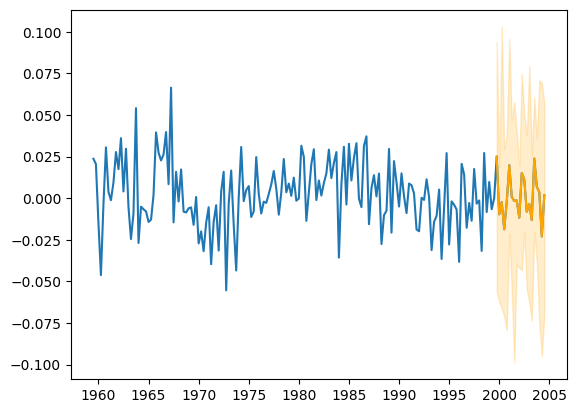

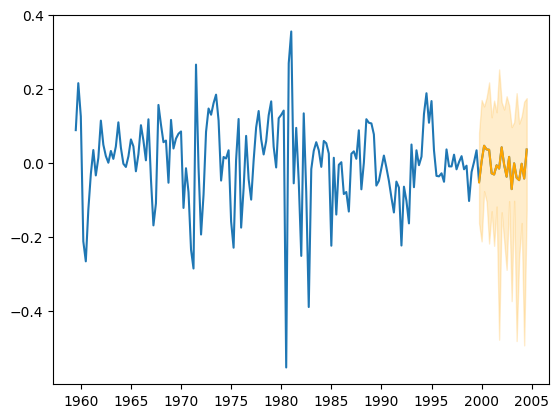

In [42]:
obj_MTS2.plot("realgovt")
obj_MTS2.plot("tbilrate")